In [0]:
import sklearn
import numpy as np 
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


**`Loading training data.`**

In [0]:
df = pd.read_csv("/content/credit_card_default_train.csv")

**Converting object type data columns into categorical type.**

In [0]:
df["EDUCATION_STATUS"] = df["EDUCATION_STATUS"].astype('category')
df["MARITAL_STATUS"] = df["MARITAL_STATUS"].astype('category')
df["Gender"] = df["Gender"].astype('category')
df["AGE"] = df["AGE"].astype('category')

**Encoding Categorical columns.**

In [0]:
df["EDUCATION_STATUS"] = df["EDUCATION_STATUS"].cat.codes
df["MARITAL_STATUS"] = df["MARITAL_STATUS"].cat.codes
df["Gender"] = df["Gender"].cat.codes
df["AGE"] = df["AGE"].cat.codes

In [0]:
def normalize_Balance_Limit_V1( balance ):
  #function to format balance limit values
    if balance[-1] == "K":
        balance = eval(balance[:-1])*1000
    else:
        balance = eval(balance[:-1])*1000000
    return balance

In [0]:
df["Balance_Limit_V1"] = df["Balance_Limit_V1"].apply(lambda balance: normalize_Balance_Limit_V1( balance ))

**Exploratory Data Analysis**


Checking Class distribution.

No of possitive samples :  5330
No of negative samples :  18670


Text(0, 0.5, 'samples')

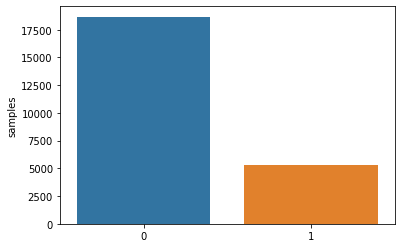

In [3]:
print("No of possitive samples : ", len(df.loc[df["NEXT_MONTH_DEFAULT"]==1]))
print("No of negative samples : ", len(df.loc[df["NEXT_MONTH_DEFAULT"]==0]))
target = df.NEXT_MONTH_DEFAULT.value_counts()
sns.barplot(target.index, target)
plt.gca().set_ylabel('samples') #gca - gets current axis of current figure

Since our dependent variable is categorical, we can split the distributions by "default/not-default" to look at the characteristics of the default/not-default groups with other features.

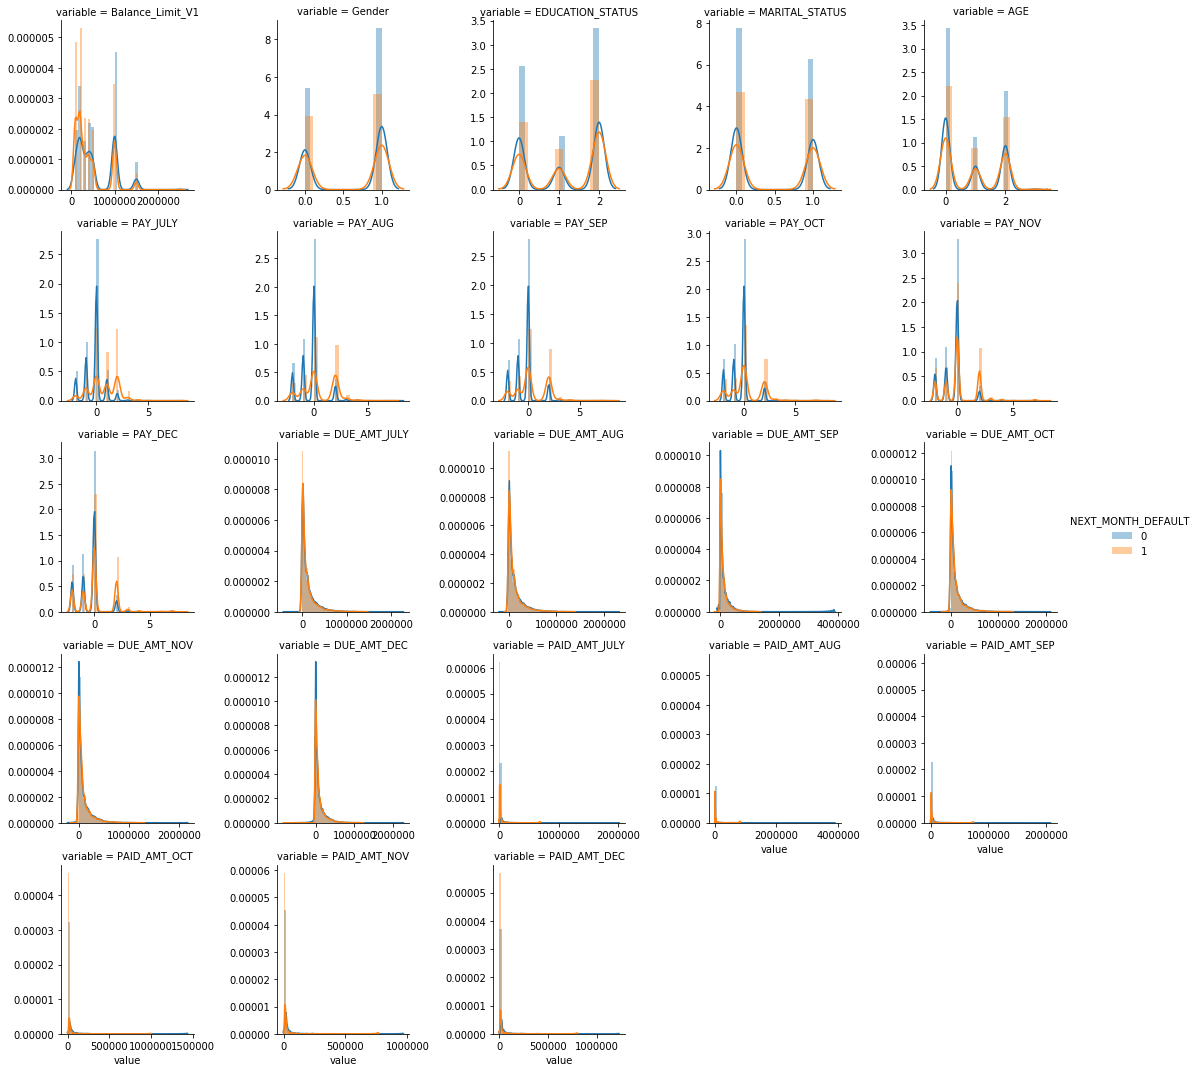

In [14]:
output = 'NEXT_MONTH_DEFAULT'

# Let's do a little EDA
cols = [ f for f in df.iloc[:,1:].columns]
cols.remove( output )

f = pd.melt( df, id_vars=output, value_vars=cols)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

**Importatnt Observations:**
1.   NonDefaults have a MUCH higher proportion of zero or negative PAY_X variables (this means that being current or ahead of payments is associated with not defaulting in the following month). This is a strong relationship as the distribution are more separated - so we expect the PAY_X to be important!
2.   Defaults have a higher proportion of Lower BAL_LIMIT values.


In [0]:
df.columns #column names

**Selecting features based on correlation.** 

Generating the correlation matrix

In [0]:
data = df.iloc[:,1:]  #data includes all columns including target except client id

In [0]:
def correlation_heatmap(data):
    correlations = data.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=False, cbar_kws={"shrink": .70})
    plt.show()
    return correlations


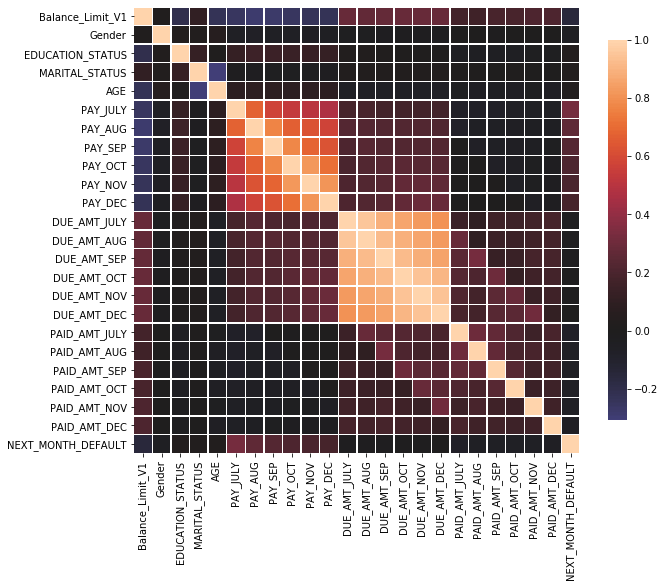

In [0]:
correlations = correlation_heatmap(data)

In [0]:
columns = np.full((correlations.shape[0],), True, dtype=bool)
for i in range(correlations.shape[0]):
    for j in range(i+1, correlations.shape[0]):
        if correlations.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data= data[selected_columns]


In [0]:
train_X = data.iloc[:,:-1]
train_Y = data.iloc[:,-1]

raw_data = train_X

In [0]:
train_X.var()

Balance_Limit_V1    1.628287e+11
Gender              2.395037e-01
EDUCATION_STATUS    8.196033e-01
MARITAL_STATUS      2.480227e-01
AGE                 8.058667e-01
PAY_JULY            1.265393e+00
PAY_AUG             1.441358e+00
PAY_SEP             1.437301e+00
PAY_OCT             1.360973e+00
PAY_NOV             1.281095e+00
PAY_DEC             1.317553e+00
DUE_AMT_JULY        2.925551e+10
PAID_AMT_JULY       1.549006e+09
PAID_AMT_AUG        3.190655e+09
PAID_AMT_SEP        1.653173e+09
PAID_AMT_OCT        1.313840e+09
PAID_AMT_NOV        1.298941e+09
PAID_AMT_DEC        1.792547e+09
dtype: float64

**Performing *PCA* on the train set for feature extraction**

**Standardising features to have a mean = 0 and SD = 1**


In [0]:
standardScaler = preprocessing.StandardScaler()

In [0]:
for feature in train_X.columns:
  train_X[feature]= standardScaler.fit_transform(train_X[feature].values.reshape(-1,1))

**Dividing the dataset into train and test sets.**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
...     train_X, train_Y, test_size=0.1, random_state=42)

**Applying PCA to the train set**

In [0]:
pca = PCA(.95) #keeping 95% of variance from the original dataset
pca.fit(X_train) #only to the train set
X_train_pca = pca.transform(X_train)

In [0]:
pca.n_components_

15